In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import tiktoken
from matplotlib import pyplot as plt


from Transformers.TransformerBlock.task import Block
from Transformers.TokenizationTiktoken.task import tokenization

In [4]:
# hyper-parameters
torch.manual_seed(36)
batch_size = 16 
block_size = 32
max_iters = 5000
eval_interval = 500
learning_rate = 1e-3
device = ("cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
eval_iters = 100
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0

Let's start by opening the text that our model will learn from and translating it into a set of tokens

Dividing the data

In [5]:
with open('shakespeare.txt', 'r', encoding='utf-8') as f:
    text = f.read()
encoded_text, stoi, itos = tokenization(text)
vocab_size = len(stoi)
data = torch.tensor(encoded_text, dtype=torch.long).to(device)

In [6]:
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

A function that returns a batch of data

In [7]:
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

In [8]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


The most important part is actually our model, which contains everything that you have written before

In [9]:
class GPT2(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) 
        self.lm_head = nn.Linear(n_embd, vocab_size)
    def forward(self, idx, targets=None):
        B, T = idx.shape

        tok_emb = self.token_embedding_table(idx) 
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) 
        x = tok_emb + pos_emb 
        x = self.blocks(x) 
        x = self.ln_f(x) 
        logits = self.lm_head(x) 

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1) 
            idx_next = torch.multinomial(probs, num_samples=1) 
            idx = torch.cat((idx, idx_next), dim=1) 
        return idx

In [10]:
model = GPT2()
m = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

step 0: train loss 9.5655, val loss 9.5671
step 500: train loss 5.7387, val loss 6.2053
step 1000: train loss 5.1880, val loss 5.8277
step 1500: train loss 4.9037, val loss 5.6787
step 2000: train loss 4.6637, val loss 5.6051
step 2500: train loss 4.5317, val loss 5.6129
step 3000: train loss 4.4026, val loss 5.6697
step 3500: train loss 4.2927, val loss 5.6086
step 4000: train loss 4.2730, val loss 5.6043
step 4500: train loss 4.1510, val loss 5.6226
step 4999: train loss 4.0518, val loss 5.6529


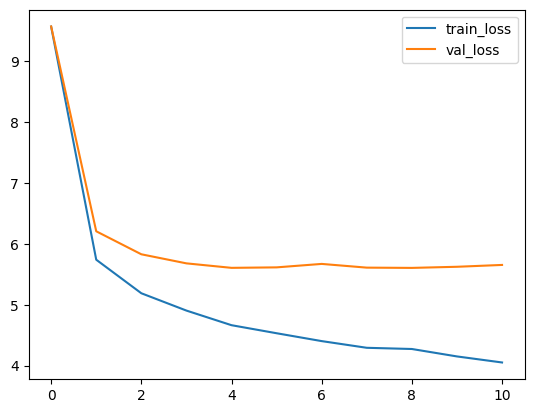

In [11]:
training_loss = []
validation_loss = []
for iter in range(max_iters):
    
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        training_loss.append(losses['train'])
        validation_loss.append(losses['val'])
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    xb, yb = get_batch('train')
    
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
plt.plot(training_loss, label='train_loss')
plt.plot(validation_loss,label='val_loss')
plt.legend()
plt.show()

In [12]:
encoding = tiktoken.get_encoding("cl100k_base")
s = "i remember a wonderful moment"
ids = encoding.encode(s)
context = torch.tensor([stoi[x] for x in ids], dtype=torch.long, device=device).view(1, len(ids))
predict = m.generate(context, max_new_tokens=100)[0].tolist()
print(encoding.decode([itos[i] for i in predict]))

i remember a wonderful moment
Whereave my lordship.

HASTINGS:
This is elevent of my lord; I love thee to help him:
Hunts'd me, which look with I tell us?

Nurse:
Ay sovereign, but that dimm me, and bring our house
Only 'twere well denied their compell.
Grace you the Tower to this nature-ote,
During it, will appear; unwilling, a villain.

CLARENCE:
There is your majesty.

KING EDWARD


Don't be afraid of what your model gives out :)
In reality, such models are trained on a huge array of data and have an incredible number of parameters, but even our small example shows how the model captures the connection between some words.